In [1]:
import numpy as np
import gizmo_analysis as gizmo
import utilities as ut
from matplotlib import pyplot as plt
import astropy
from IPython.display import clear_output
import matplotlib.ticker as ticker
from operator import add,sub,mul
import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy import optimize, stats
import emcee
import corner

plt.rcParams["font.family"] = "Serif"
plt.rcParams.update({'font.size': 10, 'font.weight' : 100})

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import random
import imageio

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Dictionary with galaxy name and corresponding local directory containing the HDF5 - for ease of access. 

dirs = { 'm11b_hires' : 'D:\Data\m11b_res260' , 'm11q' : 'D:\Data\m11q_res880', 
       'm11h' : 'D:\Data\m11h_res880', 'm10v' : 'D:\Data\m10v_res250',
       'm11d' : 'D:\Data\m11d_res7100', 'm12i' : 'D:\Data\m12i_res7100',
       'm12i_low_res' : 'D:\Data\m12i_res57000', 'm11e' : 'D:\Data\m11e_res7100',
       'm11i' : 'D:\Data\m11i_res7100', 'm10q' : 'D:\Data\m10q_res250',
       'm09' : 'D:\Data\m09_res30', 'm11b_nvm' : 'D:\Data\m11b_res2100_v2',
       'm11b' : 'D:\Data\m11bfin'}


# Function below loads the snapshot 600 from the directory that it has been assigned to. Simply use the galaxy's name
# in lowercase to get your data.


def load(galaxy):
    
    print('LOADING GALAXY: ' + galaxy + " in " + dirs[galaxy])
    
    part = gizmo.io.Read.read_snapshots(['star'], 'index', 600, assign_hosts = 'mass', assign_hosts_rotation=True,
                                        simulation_name=str(galaxy), simulation_directory=dirs[galaxy], 
                                        assign_formation_coordinates = False)
    
    species='star'
    mass = part[species].prop('mass')
    age = part[species].prop('age')
    feh  = part[species].prop('metallicity.fe')
    sife = part[species].prop('metallicity.si - metallicity.fe')
    cafe = part[species].prop('metallicity.ca - metallicity.fe') 
    ofe = part[species].prop('metallicity.o - metallicity.fe') 
    afe = part[species].prop('metallicity.alpha - metallicity.fe') 
    
    Rxy = part[species].prop('host.distance.principal.cylindrical')[:,0]
    z = part[species].prop('host.distance.principal.cylindrical')[:,1]
    mgfe = part[species].prop('metallicity.mg - metallicity.fe')
    
    x = part[species].prop('host.distance.principal')[:,0]
    y = part[species].prop('host.distance.principal')[:,1]
    z = part[species].prop('host.distance.principal')[:,2]
    
    R = part[species].prop('host.distance.principal.cylindrical')[:,0]
    phi = part[species].prop('host.distance.principal.cylindrical')[:,2]*(180.0/np.pi)
    #form = part[species].prop('form.host.distance.principal.cylindrical')
    
    return part, mass, age, feh, sife, cafe, ofe, z, mgfe, x, y, R, phi#,form

In [3]:
parts = [] #empty array that will contain part files
masses =[]
ages = [] # ... ages
sifes = []
cafes =[]
fehscs = [] #empty array that will contain [Fe/H] values for each galaxy
ofescs = [] #empty array that will contain [O/Fe] values for each galaxy
zs = []
mgfes = []
xs = []
ys = []
Rs = []
phis = []
#forms = []

names = ['m11i', 'm11b', 'm11h', 'm10q'] #names of each galaxy. will be iterated over to
# access the dictionary

for i in range(0,len(names)):
    part, mass , age, feh, sife, cafe, ofe, z, mgfe, x, y, R, phi = load(names[i])
    parts.append(part), masses.append(mass), ages.append(age), fehscs.append(feh), sifes.append(sife), cafes.append(cafe),
    ofescs.append(ofe), zs.append(z), mgfes.append(mgfe), xs.append(x), ys.append(y), Rs.append(R), phis.append(phi),
    clear_output() # NOTE MAY NEED TO APPEND FORMS IF LOOKING AT RFORM
    
print(str(names) + " loaded!")

['m11i', 'm11b', 'm11h', 'm10q'] loaded!


In [4]:
f_o, df_o, m_o, dm_o = np.genfromtxt("Fornax.txt", unpack = True, delimiter = ",")

print(np.min(df_o))
print(np.max(df_o))
print(np.mean(df_o))

nanind = np.where(m_o == m_o)

print(np.min(dm_o[nanind]))
print(np.max(dm_o[nanind]))
print(np.mean(dm_o[nanind]))

0.1
0.16
0.10411910669975188
0.11
0.3
0.20545893719806763


0.02165063509461097
Avg s[Fe/H]: 0.0425
Avg s[Mg/Fe]: 0.0675
0.019202864369671523
0.02165063509461097


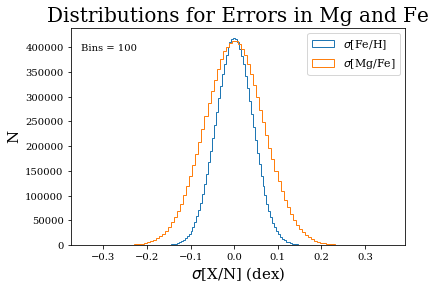

In [11]:
f_o, df_o, m_o, dm_o = np.genfromtxt("Fig_SyntheticObs/Ursaminor.txt", unpack = True, delimiter = ",")

f_o = [.02,.03,.05,.07]
df_o = [.02,.03,.05,.07]
m_o = [.04,.06,.07,.1]
dm_o = [.04,.06,.07,.1]

feh_o = f_o
dfeh_o = df_o
mgfe_o = m_o
dmgfe_o = dm_o

#sel_ind1 = np.where((df_o < 0.3) & (dm_o < 0.3))
#sel_ind2 = np.where((df_o < 0.3) & (m_o != 0) & (dm_o < 0.3))
nanind = np.where(m_o == m_o)
#
#feh_o = f_o
#dfeh_o = df_o[np.where(df_o < 0.3)]
#mgfe_o = m_o[nanind]
#dmgfe_o = dm_o[nanind][np.where(dm_o[nanind] < 0.3)]

avg_f = np.average(dfeh_o)
s_f = np.std(dfeh_o)
avg_m = np.average(dmgfe_o)
s_m = np.std(dmgfe_o)

print(s_m)
print("Avg s[Fe/H]: " + str(avg_f))
print("Avg s[Mg/Fe]: " + str(avg_m))
print(s_f)
print(s_m)
feh_err = np.random.normal(0, avg_f, 10000000)
mgfe_err = np.random.normal(0, avg_m, 10000000)

fig = plt.figure(figsize = (6,4))
plt.hist(feh_err, bins = 100, label = r'$\sigma$[Fe/H]', histtype = 'step')
plt.hist(mgfe_err, bins = 100, label =r'$\sigma$[Mg/Fe]', histtype = 'step')
plt.title("Distributions for Errors in Mg and Fe", size = 20)
plt.ylabel("N", size = 15)
plt.xlabel(r"$\sigma$[X/N] (dex)", size = 15)
plt.legend(fontsize = 11)
fig.text(.15,.8, 'Bins = 100')
plt.savefig("Fig_SyntheticObs/Distribution_of_errors_" + "jwst" + ".png", bbox_inches = 'tight')
plt.show()

In [12]:
feh_err[63213]

0.009875497542262055

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


0.1
1


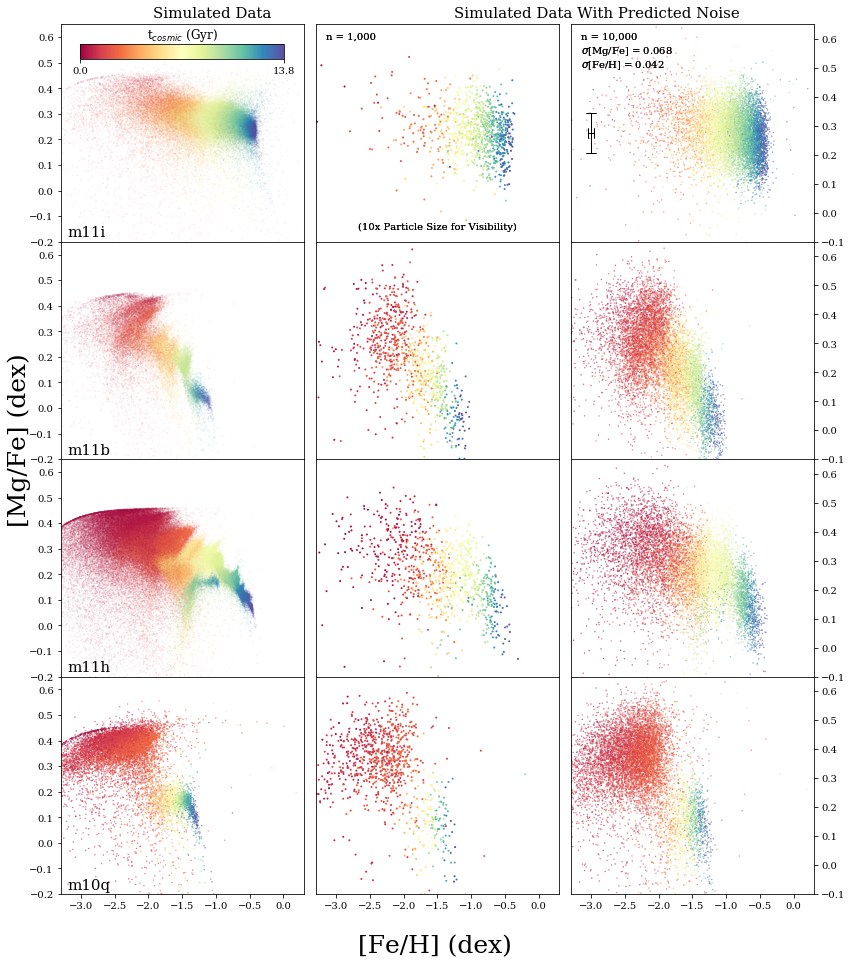

In [13]:
# Creates a figure with 9 subplots.
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9), (ax10,ax11,ax12)) = plt.subplots(nrows=4, ncols=3, sharex = True,
                           figsize=(13.5,16))

axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9, ax10, ax11, ax12] #initializing the subplots
plots = [] #this will be used for the embedded colorbars if creating hist2d
ssize = [0,1000,10000,0,1000,10000,0,1000,10000, 0,1000,10000] # Number of data points
scatter_sizes = [0.003,0.003,0.003,0.1]

fig.text(0.07,0.52,"[Mg/Fe] (dex)", va = 'center', size = 25, rotation = 90)
fig.text(0.51,0.074, "[Fe/H] (dex)", ha = 'center', size = 25)

ind = np.where(Rs[0] < 20)
counts1,xbins1,ybins1,image1 = plt.hist2d(fehscs[0][ind], mgfes[0][ind], bins = [100,100])


#mean age for bins of stars in mgfe vs feh space
mean_age1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(fehscs[0][ind], mgfes[0][ind], 
                                                                    ages[0][ind], 'mean', bins= [100,100])

#masks below cuts out where there are fewer stars than a particular threshold
m1 = np.ma.masked_where(counts1 < 1,  mean_age1)
im = axes[0].imshow(m1.transpose(), interpolation='nearest', origin='low', 
                extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = 'Spectral', aspect='auto', vmin=0, vmax=13.8)
axes[0].clear()

cbar_ax = fig.add_axes([ 0.145, 0.85, 0.21, 0.0125]) #left, bottom, width, height  # vertically oriented colorbar

cb = fig.colorbar(im, cax=cbar_ax, ticks = [0,13.8],  orientation = 'horizontal')
#cb.ax.yaxis.set_ticks_position("right")
cb.ax.set_yticklabels(['0 Gyr', '13.8 Gyr'], fontweight = 15) # Used to make custom labels on the tick marks themselves
cb.ax.set_title(r"t$_{cosmic}$ (Gyr)")
#cb.ax.yaxis.set_label_position("left")


for i in range(0,4):
        axes[3*i].scatter(fehscs[i][np.where(Rs[i] < 20)] , mgfes[i][np.where(Rs[i] < 20)], c = 13.7987-ages[i][np.where(Rs[i] < 20)], 
                        cmap = 'Spectral', s = scatter_sizes[i])
        axes[3*i].set_xlim(-3.3, 0.)
        axes[3*i].set_ylim(-0.2, 0.65)   
        axes[3*i].text(-3.2,-.18,names[i], size = 15)

cf = .1 #correctional factor for different plots
x_min = -3.3
x_max = 0.3
y_min = -.1 
y_max = 0.75 - .1

sizes2 = [0.1,1,0.1]

for i in range(0,12):
    if((i > 0) & (i < 3)):
        # format - property_list[specific galaxy index (0,1, or 2)][index (within 20 kpc)] #
        rand_ind = random.sample(list(np.arange(0,len(fehscs[0][np.where(Rs[0] < 20)]))), ssize[i])
        axes[i].scatter(fehscs[0][np.where(Rs[0] < 20)][rand_ind]+feh_err[rand_ind], 
                        mgfes[0][np.where(Rs[0] < 20)][rand_ind]+mgfe_err[rand_ind], 
                        c = 13.7987-ages[0][np.where(Rs[0] < 20)][rand_ind], 
                        cmap = 'Spectral', s = sizes2[(i%3)])
        axes[i].set_xlim(x_min, x_max)
        axes[i].set_ylim(y_min, y_max)
        axes[i].text(-3.2,.02-.1-cf,"N = "+str(ssize[i]), size = 13)
        axes[1].text(-1.5, -0.0575, "(10x Particle Size for Visibility)", ha = 'center')
        print(sizes2[i%3 - 1])

    if((i > 3) & (i < 6)):
        rand_ind = random.sample(list(np.arange(0,len(fehscs[1][np.where(Rs[1] < 20)]))), ssize[i])
        axes[i].scatter(fehscs[1][np.where(Rs[1] < 20)][rand_ind]+feh_err[rand_ind], 
                        mgfes[1][np.where(Rs[1] < 20)][rand_ind]+mgfe_err[rand_ind], 
                        c = 13.7987-ages[1][np.where(Rs[1] < 20)][rand_ind], 
                        cmap = 'Spectral', s = sizes2[(i%3)])
        axes[i].set_xlim(x_min, x_max)
        axes[i].set_ylim(y_min, y_max)
        
    if((i > 6) & (i < 9)):
        rand_ind = random.sample(list(np.arange(0,len(fehscs[2][np.where(Rs[2] < 20)]))), ssize[i])
        axes[i].scatter(fehscs[2][np.where(Rs[2] < 20)][rand_ind]+feh_err[rand_ind], 
                                                        mgfes[2][np.where(Rs[2] < 20)][rand_ind]+mgfe_err[rand_ind], 
                                                        c = 13.7987-ages[2][np.where(Rs[2] < 20)][rand_ind], 
                                                        cmap = 'Spectral', s = sizes2[(i%3)])
        axes[i].set_xlim(x_min, x_max)
        axes[i].set_ylim(y_min, y_max)
        
    if((i > 9) & (i < 12)):
        axes[11].clear()
        rand_ind = random.sample(list(np.arange(0,len(fehscs[3][np.where(Rs[3] < 20)]))), ssize[i])
        axes[i].scatter(fehscs[3][np.where(Rs[3] < 20)][rand_ind]+feh_err[rand_ind], 
                        mgfes[3][np.where(Rs[3] < 20)][rand_ind]+mgfe_err[rand_ind], 
                        c = 13.7987-ages[3][np.where(Rs[3] < 20)][rand_ind], 
                        cmap = 'Spectral', s = sizes2[(i%3)])
        axes[i].set_xlim(x_min, x_max)
        axes[i].set_ylim(y_min, y_max)

        axes[2].errorbar(-3, (y_max+y_min)/2, yerr = (avg_m), xerr = avg_f,  capsize = 5, capthick = 1, ecolor = 'black', elinewidth = 1)
        axes[2].text(-3.15, .65 - cf, r"$\sigma$[Mg/Fe] = " + str(round(avg_m,3)), size = 10, ha = 'left')
        axes[2].text(-3.15, .6 - cf, r"$\sigma$[Fe/H] = " + str(round(avg_f,3)), size = 10, ha = 'left')
        axes[2].text(-3.15, .7 - cf, "n = 10,000", size = 10, ha = 'left')
        
        axes[1].text(-3.15, .7 - cf, "n = 1,000", size = 10, ha = 'left')

boxesoi = [1,2,3,5]
for i in boxesoi:
    axes[i].get_xaxis().set_visible(False)
    
boxesoi = [1,4,7,10]
for i in boxesoi:
    axes[i].get_yaxis().set_visible(False)   
    
boxesoi = [2,5,8,11]
for i in boxesoi:
    axes[i].get_yaxis().tick_right()

fig.text(0.22, 0.886, "Simulated Data", size = 15)
fig.text(0.53, 0.886, "Simulated Data With Predicted Noise", size = 15)

plt.subplots_adjust(wspace=.05, hspace=.0)
plt.savefig("m11i_Error_jwst.png", dpi = 150)

In [45]:
# Creates a figure with 9 subplots.
#fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9), (ax10,ax11,ax12)) = plt.subplots(nrows=4, ncols=3, sharex = True,
#                           figsize=(13.5,12))
#
#axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9, ax10, ax11, ax12] #initializing the subplots
#plots = [] #this will be used for the embedded colorbars if creating hist2d
#ssize = [0,1000,10000,0,1000,10000,0,1000,10000] # Number of data points
#scatter_sizes = [0.01,0.01,0.003,0.1]
#
#fig.text(0.07,0.52,"[Mg/Fe] (dex)", va = 'center', size = 25, rotation = 90)
#fig.text(0.51,0.074, "[Fe/H] (dex)", ha = 'center', size = 25)
#
#ind = np.where(Rs[0] < 20)
#counts1,xbins1,ybins1,image1 = plt.hist2d(fehscs[0][ind], mgfes[0][ind], bins = [100,100])
#
#
##mean age for bins of stars in mgfe vs feh space
#mean_age1, xedges1, yedges1, binnumber1 = stats.binned_statistic_2d(fehscs[0][ind], mgfes[0][ind], 
#                                                                    ages[0][ind], 'mean', bins= [100,100])
#
##masks below cuts out where there are fewer stars than a particular threshold
#m1 = np.ma.masked_where(counts1 < 1,  mean_age1)
#im = axes[0].imshow(m1.transpose(), interpolation='nearest', origin='low', 
#                extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]], cmap = 'Spectral', aspect='auto', vmin=0, vmax=13.8)
#axes[0].clear()
#
#cbar_ax = fig.add_axes([ 0.145, 0.835, 0.21, 0.02]) #left, bottom, width, height  # vertically oriented colorbar
#
#cb = fig.colorbar(im, cax=cbar_ax, ticks = [0,13.8],  orientation = 'horizontal')
##cb.ax.yaxis.set_ticks_position("right")
#cb.ax.set_yticklabels(['0 Gyr', '13.8 Gyr'], fontweight = 15) # Used to make custom labels on the tick marks themselves
#cb.ax.set_title(r"t$_{cosmic}$ (Gyr)")
##cb.ax.yaxis.set_label_position("left")
#
#
#for i in range(0,4):
#        axes[3*i].scatter(fehscs[i][np.where(Rs[i] < 20)] , mgfes[i][np.where(Rs[i] < 20)], c = 13.7987-ages[i][np.where(Rs[i] < 20)], 
#                        cmap = 'Spectral', s = scatter_sizes[i])
#        axes[3*i].set_xlim(-3.3, 0.)
#        axes[3*i].set_ylim(-0.2, 0.65)   
#        axes[3*i].text(-3.2,-.18,names[i], size = 15)
#
#cf = .1 #correctional factor for different plots
#x_min = -3.3
#x_max = 0
#y_min = -.1 - cf
#y_max = 0.75 - cf
#        
#for i in range(0,12):
#    if((i > 0) & (i < 3)):
#        # format - property_list[specific galaxy index (0,1, or 2)][index (within 20 kpc)] #
#        rand_ind = random.sample(list(np.arange(0,len(fehscs[0][np.where(Rs[0] < 20)]))), ssize[i])
#        axes[i].scatter(fehscs[0][np.where(Rs[0] < 20)][rand_ind]+feh_err[rand_ind], 
#                        mgfes[0][np.where(Rs[0] < 20)][rand_ind]+mgfe_err[rand_ind], 
#                        c = 13.7987-ages[0][np.where(Rs[0] < 20)][rand_ind], 
#                        cmap = 'Spectral', s = .1)
#        axes[i].set_xlim(x_min, x_max)
#        axes[i].set_ylim(y_min, y_max)
#        axes[i].text(-3.2,.02-.1-cf,"N = "+str(ssize[i]), size = 13)
#
#        
#    if((i > 6) & (i < 9)):
#        rand_ind = random.sample(list(np.arange(0,len(fehscs[1][np.where(Rs[1] < 20)]))), ssize[i])
#        axes[i].scatter(fehscs[1][np.where(Rs[1] < 20)][rand_ind]+feh_err[rand_ind], 
#                        mgfes[1][np.where(Rs[1] < 20)][rand_ind]+mgfe_err[rand_ind], 
#                        c = 13.7987-ages[1][np.where(Rs[2] < 20)][rand_ind], 
#                        cmap = 'Spectral', s = .1)
#        axes[i].set_xlim(x_min, x_max)
#        axes[i].set_ylim(y_min, y_max)
#        
#    if((i > 9) & (i < 12)):
#        axes[11].clear()
#        rand_ind = random.sample(list(np.arange(0,len(fehscs[2][np.where(Rs[2] < 20)]))), ssize[i])
#        axes[i].scatter(fehscs[2][np.where(Rs[2] < 20)][rand_ind]+feh_err[rand_ind], 
#                        mgfes[2][np.where(Rs[2] < 20)][rand_ind]+mgfe_err[rand_ind], 
#                        c = 13.7987-ages[2][np.where(Rs[3] < 20)][rand_ind], 
#                        cmap = 'Spectral', s = .1)
#        axes[i].set_xlim(x_min, x_max)
#        axes[i].set_ylim(y_min, y_max)
#
#        axes[2].errorbar(-0.4, (y_max+y_min)/2, yerr = (avg_m), xerr = avg_f,  capsize = 5, capthick = 1, ecolor = 'black', elinewidth = 1)
#        axes[2].text(-.1, .7 - cf, r"$\sigma$[Mg/Fe] = " + str(round(avg_m,3)), size = 10, ha = 'right')
#        axes[2].text(-.1, .65 - cf, r"$\sigma$[Fe/H] = " + str(round(avg_f,3)), size = 10, ha = 'right')
#
#boxesoi = [1,2,3,5]
#for i in boxesoi:
#    axes[i].get_xaxis().set_visible(False)
#    
#boxesoi = [1,4,7]
#for i in boxesoi:
#    axes[i].get_yaxis().set_visible(False)   
#    
#boxesoi = [2,5,8]
#for i in boxesoi:
#    axes[i].get_yaxis().tick_right()
#
#fig.text(0.22, 0.886, "Simulated Data", size = 15)
#fig.text(0.56, 0.886, "Simulated Data With Forecasted Noise (JWST)", size = 15)
#
#plt.subplots_adjust(wspace=.05, hspace=.0)
#plt.savefig("synthetic_JWST_error.png", dpi = 150)

AttributeError: Unknown property nrows

<Figure size 432x288 with 0 Axes>

In [59]:
scores = [28.5/30 , 59/60, 52.5/60,  59/60, 55.5/60, 49/100, 56/60, 59/60, 65/100]
xs = np.linspace(0, len(scores), 9)

import scipy as scipy
f2 = scipy.interpolate.interp1d(xs, scores, kind='quadratic')
xs2 = np.linspace(0,9,10000)

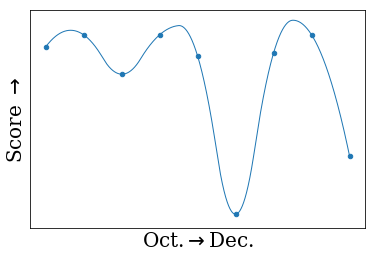

In [67]:
plt.scatter(xs,scores, s = 20)
plt.plot(xs2,f2(xs2), lw = 1)
ax = plt.gca()
ax.axes.yaxis.set_ticklabels([])
ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_ticklabels([])
ax.axes.xaxis.set_ticks([])

plt.ylabel(r"Score $\rightarrow$", size = 20)
plt.xlabel("Oct." + r'$\rightarrow$' + 'Dec.', size = 20)
plt.show()